In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from pathlib import Path
from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

In [4]:
positive_dir = Path('../input/surface-crack-detection/Positive')
negative_dir = Path('../input/surface-crack-detection/Negative')

In [5]:
def generate_df(image_dir, label):
    filepaths = pd.Series(list(image_dir.glob(r'*.jpg')), name='Filepath').astype(str)
    labels = pd.Series(label, name='Label', index=filepaths.index)
    df = pd.concat([filepaths, labels], axis=1)
    return df

In [6]:
positive_df = generate_df(positive_dir, label="POSITIVE")
negative_df = generate_df(negative_dir, label="NEGATIVE")
pd.Series(dtype='float64')
all_df = pd.concat([positive_df, negative_df], axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
all_df

,Filepath,Label
0,../input/surface-crack-detection/Positive/0574...,POSITIVE
1,../input/surface-crack-detection/Positive/1870...,POSITIVE
2,../input/surface-crack-detection/Positive/0967...,POSITIVE
3,../input/surface-crack-detection/Negative/0791...,NEGATIVE
4,../input/surface-crack-detection/Positive/1400...,POSITIVE
...,...,...
39995,../input/surface-crack-detection/Positive/0854...,POSITIVE
39996,../input/surface-crack-detection/Negative/1944...,NEGATIVE
39997,../input/surface-crack-detection/Positive/0977...,POSITIVE
39998,../input/surface-crack-detection/Positive/1504...,POSITIVE


In [7]:
train_df, test_df = train_test_split(
    all_df.sample(5000, random_state=1),
    train_size=0.7,
    shuffle=True,
    random_state=1
)

In [8]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [9]:
train_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_data = train_gen.flow_from_dataframe(
    train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_data = train_gen.flow_from_dataframe(
    test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='binary',
    batch_size=32,
    shuffle=False,
    seed=42
)

Found 2800 validated image filenames belonging to 2 classes.
Found 700 validated image filenames belonging to 2 classes.
Found 1500 validated image filenames belonging to 2 classes.


In [49]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,GlobalAveragePooling2D,Flatten,LSTM,TimeDistributed,Reshape

#CNN

model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(120,120,3)))
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu') )
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(GlobalAveragePooling2D())
model.add(Flatten())

model.add(Reshape((1, -1)))


In [50]:


# Add LSTM Layer
model.add(LSTM(128))

# Add Dense Layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid')) 

In [51]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 118, 118, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 59, 59, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 57, 57, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 28, 28, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 26, 26, 128)       73856     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 13, 13, 128)    

In [52]:
history2 = model.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
88/88 [==============================] - 11s 83ms/step - loss: 0.6212 - accuracy: 0.5914 - val_loss: 0.1085 - val_accuracy: 0.9900
Epoch 2/100
88/88 [==============================] - 7s 84ms/step - loss: 0.1157 - accuracy: 0.9704 - val_loss: 0.0234 - val_accuracy: 0.9943
Epoch 3/100
88/88 [==============================] - 7s 78ms/step - loss: 0.0774 - accuracy: 0.9771 - val_loss: 0.0255 - val_accuracy: 0.9929
Epoch 4/100
88/88 [==============================] - 7s 78ms/step - loss: 0.0640 - accuracy: 0.9786 - val_loss: 0.0491 - val_accuracy: 0.9829
Epoch 5/100
88/88 [==============================] - 7s 78ms/step - loss: 0.0580 - accuracy: 0.9832 - val_loss: 0.0249 - val_accuracy: 0.9943


In [53]:
def evaluate_model(model, test_data):
    
    results = model.evaluate(test_data, verbose=0)
    loss = results[0]
    acc = results[1]
    
    print("    Test Loss: {:.5f}".format(loss))
    print("Test Accuracy: {:.2f}%".format(acc * 100))
    
    y_pred = np.squeeze((model.predict(test_data) >= 0.5).astype(np.int))
    cm = confusion_matrix(test_data.labels, y_pred)
    clr = classification_report(test_data.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    
    print("Classification Report:\n----------------------\n", clr)

    Test Loss: 0.07645
Test Accuracy: 98.00%
47/47 [==============================] - 3s 57ms/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


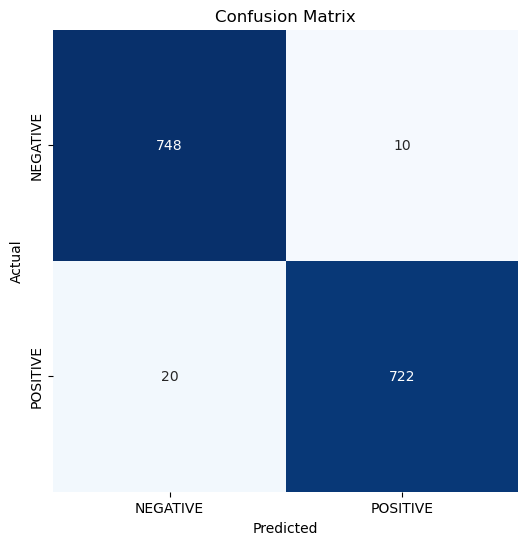

Classification Report:
----------------------
               precision    recall  f1-score   support

    NEGATIVE       0.97      0.99      0.98       758
    POSITIVE       0.99      0.97      0.98       742

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



In [54]:
evaluate_model(model, test_data)

In [55]:
model.predict(test_data)

47/47 [==============================] - 3s 56ms/step


array([[0.02827968],
       [0.99998295],
       [0.01142706],
       ...,
       [0.00562727],
       [0.00749433],
       [0.99995637]], dtype=float32)

In [62]:
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
   np_image = Image.open(filename)
   np_image = np.array(np_image).astype('float32')/255
   np_image = transform.resize(np_image, (120, 120, 3))
   np_image = np.expand_dims(np_image, axis=0)
   return np_image

image = load('/kaggle/input/test-img2/49997993-texture-of-plain-concrete-wall.webp')
pred = model.predict(image)


if pred < 0.5:
    print("No Crack")
else:
    print("Crack")
    

1/1 [==============================] - 0s 23ms/step
No Crack


In [63]:
model.save("lstm_cnn_model.h5")